In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from readability import Readability
from itertools import combinations
import glob
import yake
from tqdm import tqdm
from scipy.stats import pearsonr
import spacy
import pytextrank
from collections import defaultdict
from nltk.corpus import stopwords
from sklearn.metrics import cohen_kappa_score

sns.set_theme()
!python -m spacy download en_core_web_sm

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/icachol1/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/icachol1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/home/icachol1/.conda/envs/request-gpt/lib/python3.9/site-packages
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.1 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
output_dir = "/scratch4/mdredze1/icachol1/readability_analysis-data"
output_files = glob.glob(f"{output_dir}/meta-llama/Llama-3.3-70B-Instruct-prompt4.*.csv")
output_files

['/scratch4/mdredze1/icachol1/readability_analysis-data/meta-llama/Llama-3.3-70B-Instruct-prompt4.scitldr.csv',
 '/scratch4/mdredze1/icachol1/readability_analysis-data/meta-llama/Llama-3.3-70B-Instruct-prompt4.eureka.csv',
 '/scratch4/mdredze1/icachol1/readability_analysis-data/meta-llama/Llama-3.3-70B-Instruct-prompt4.arxiv.csv',
 '/scratch4/mdredze1/icachol1/readability_analysis-data/meta-llama/Llama-3.3-70B-Instruct-prompt4.cells.csv',
 '/scratch4/mdredze1/icachol1/readability_analysis-data/meta-llama/Llama-3.3-70B-Instruct-prompt4.cdsr.csv',
 '/scratch4/mdredze1/icachol1/readability_analysis-data/meta-llama/Llama-3.3-70B-Instruct-prompt4.skj.csv',
 '/scratch4/mdredze1/icachol1/readability_analysis-data/meta-llama/Llama-3.3-70B-Instruct-prompt4.plos.csv',
 '/scratch4/mdredze1/icachol1/readability_analysis-data/meta-llama/Llama-3.3-70B-Instruct-prompt4.pubmed.csv',
 '/scratch4/mdredze1/icachol1/readability_analysis-data/meta-llama/Llama-3.3-70B-Instruct-prompt4.elife.csv',
 '/scratch

In [3]:
def get_summaries(d_name):
    f_name = f'/scratch4/mdredze1/icachol1/layscisum/targets/{d_name}.target'
    lines = open(f_name).readlines()
    return [l.strip() for l in lines]

In [4]:
def get_scores(files_list):
    objs = []
    for f_name in files_list:
        df = pd.read_csv(f_name)
        try:
            scores = df['reading_ease'].to_list()
            responses = df['response'].to_list()
            dataset = f_name.split('.')[-2]
            summaries = get_summaries(dataset)
            print(len(scores), len(summaries))
            model = f_name.split('.')[-3]
            objs.append(
                pd.DataFrame.from_dict(
                    {
                    'readability': scores, 
                    'summary': summaries,
                    'response': responses, 
                    'dataset': dataset, 
                    'model': model})
            )
        except KeyError:
            print(f_name)
    return pd.concat(axis=0, ignore_index=True, objs=objs)
all_scores = get_scores(output_files)
all_scores

618 618
1010 1010
6440 6440
6311 6311
53 53
284 284
1376 1376
6657 6657
241 241
4188 4188


,readability,summary,response,dataset,model
0,2.0,"FearNet is a memory efficient neural-network, ...",I would rate the reading ease of this text as ...,scitldr,3-70B-Instruct-prompt4
1,2.0,Multi-view learning improves unsupervised sent...,I would rate the reading ease of the text as a...,scitldr,3-70B-Instruct-prompt4
2,2.0,We show how discrete objects can be learnt in ...,I would rate the reading ease of the text as a...,scitldr,3-70B-Instruct-prompt4
3,4.0,A large-scale dataset for training attention m...,I would rate the reading ease of the text as a...,scitldr,3-70B-Instruct-prompt4
4,2.0,We proposed a time-efficient defense method ag...,I would rate the reading ease of this text as ...,scitldr,3-70B-Instruct-prompt4
...,...,...,...,...,...
27173,3.0,A key technical challenge in creating new sulf...,I would rate the reading ease of this text as ...,scinews,3-70B-Instruct-prompt4
27174,3.0,Increased carbon sequestration in soil to help...,I would rate the reading ease of this text a 3...,scinews,3-70B-Instruct-prompt4
27175,4.0,Medicines such as insulin for diabetes and clo...,I would rate the reading ease of this text as ...,scinews,3-70B-Instruct-prompt4
27176,2.0,The electronic structure of nonmagnetic crysta...,I would rate the reading ease of this text as ...,scinews,3-70B-Instruct-prompt4


In [6]:
def get_readability(text):
  try:
    r = Readability(text)
    return r.coleman_liau().score
  except:
    return -1
text = """
  In linguistics, the Gunning fog index is a readability test for English writing. The index estimates the years of formal education a person needs to understand the text on the first reading. For instance, a fog index of 12 requires the reading level of a United States high school senior (around 18 years old). The test was developed in 1952 by Robert Gunning, an American businessman who had been involved in newspaper and textbook publishing.
  The fog index is commonly used to confirm that text can be read easily by the intended audience. Texts for a wide audience generally need a fog index less than 12. Texts requiring near-universal understanding generally need an index less than 8.
  """
get_readability(text)

10.673162393162393

In [7]:
all_scores['coleman_liau'] = all_scores['summary'].apply(get_readability)

In [8]:
def get_aggreement_from_binary(r_level, lm_level):
    try:
        tmp = all_scores[all_scores['coleman_liau'] != -1]
        clbinary = tmp['coleman_liau'] < r_level
        lm_binary = tmp['readability'] >= lm_level
        tmp['clbinary'] = clbinary.apply(int)
        tmp['lm_binary'] = lm_binary.apply(int)
        return cohen_kappa_score(tmp['clbinary'], tmp['lm_binary'])
    except:
        return -10000
get_aggreement_from_binary(12, 4)

/tmp/ipykernel_453495/3608487856.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['clbinary'] = clbinary.apply(int)
/tmp/ipykernel_453495/3608487856.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['lm_binary'] = lm_binary.apply(int)


0.22059270529236152

In [9]:
cl_df = all_scores[all_scores['coleman_liau'] != -1]
pearsonr(cl_df['coleman_liau'], cl_df['readability'])

PearsonRResult(statistic=-0.2321796345897468, pvalue=3.9465885975939065e-288)

In [10]:
cl_df[(cl_df['coleman_liau'] > 13) & (cl_df['readability'] > 4)].iloc[0]

readability                                                   5.0
summary         There is a global need for more sustainable an...
response        I would rate the reading ease of this text as ...
dataset                                                       skj
model                                      3-70B-Instruct-prompt4
coleman_liau                                            13.187239
Name: 14712, dtype: object

In [11]:
cl_df[(cl_df['coleman_liau'] > 13) & (cl_df['readability'] > 4)].iloc[0]['summary']

'There is a global need for more sustainable and environmentally friendly construction materials. The large, stable mounds that termites build for their homes are inspirational! Termite mounds form when the termites mix soil with their saliva. This mixture contains simple sugars that act like glue and give it stability. Cassava is a starchy root vegetable that also contains simple sugars. To mimic termite mounds, we mixed soil with hot paste made from cassava flour. Then, we made bricks containing different amounts of cassava flour paste, from 0% to 6%. We tested the physical properties of these different bricks. Our aim was to see how suitable they would be in building construction. Bricks made with 1.5% cassava flour paste performed best in tests of strength, durability, shrinkage, and water absorption. They were even better than traditional clay bricks with no cassava flour! Our termite mound-inspired bricks provide an inexpensive, accessible, and safe alternative to current buildin

In [12]:
cl_df[(cl_df['coleman_liau'] < 11) & (cl_df['readability'] < 3)]

,readability,summary,response,dataset,model,coleman_liau
1646,1.0,we compute the one - loop corrections to the @...,I would rate the reading ease of this text as ...,arxiv,3-70B-Instruct-prompt4,10.445172
1717,1.0,in this talk i discuss three related topics ba...,I would rate the reading ease of this text as ...,arxiv,3-70B-Instruct-prompt4,9.504596
1752,1.0,a model of quark mass matrices from six dimens...,I would rate the reading ease of this text as ...,arxiv,3-70B-Instruct-prompt4,9.000702
1754,1.0,light curve analysis of decay phase of nova ou...,I would rate the reading ease of this text as ...,arxiv,3-70B-Instruct-prompt4,10.176129
1844,1.0,the distant globular cluster palomar 13 has be...,I would rate the reading ease of this text as ...,arxiv,3-70B-Instruct-prompt4,9.721301
...,...,...,...,...,...,...
22986,2.0,If all the DNA contained within a single human...,I would rate the reading ease of this text as ...,elife,3-70B-Instruct-prompt4,9.304650
23068,2.0,Most of today's anticancer drugs target the DN...,I would rate the reading ease of this text as ...,scinews,3-70B-Instruct-prompt4,10.794443
24060,2.0,The rapid emergence of new strains of the SARS...,I would rate the reading ease of this text as ...,scinews,3-70B-Instruct-prompt4,10.913078
24173,2.0,A new study led by scientists at Sanford Burnh...,I would rate the reading ease of this text as ...,scinews,3-70B-Instruct-prompt4,10.499044


In [13]:
cl_df[(cl_df['coleman_liau'] < 12) & (cl_df['readability'] < 3)].loc[21962]

KeyError: 21962

In [ ]:
cl_df[(cl_df['coleman_liau'] < 12) & (cl_df['readability'] < 3)].loc[21962]['summary']

'New egg cells form via a specialized kind of cell division called called meiosis , and will pause at key stages in this process before continuing their development . One of these pauses occurs before the egg cell is fertilized . At fertilization , the egg cell becomes “activated” , development resumes , and it starts forming into an embryo . Molecules deposited in the egg cell when it originally formed are used to control these earliest stages of embryonic development . These molecules include messenger RNA molecules ( mRNAs for short ) , which can be “translated” to build proteins . In fruit flies , an enzyme called PNG kinase regulates the translation of hundreds of mRNA molecules during the period after the pause , when the maturing egg cell is activated and the embryo begins to develop . It is not well understood what activates and inactivates the kinase to limit its activity to this period of time . However , it was known that a protein called GNU was needed to bind to the PNG ki

In [ ]:
cl_df[(cl_df['coleman_liau'] < 12) & (cl_df['readability'] < 3)].loc[21962]['response']

'I would rate the reading ease of this text as a 2 out of 5. The text assumes a significant amount of background knowledge in cell biology, genetics, and molecular biology, including terms such as meiosis, messenger RNA, kinase, and phosphate groups. The text also uses technical vocabulary and complex sentence structures, which may make it challenging for non-experts to follow.\n\nWhile the text does provide some explanations and definitions for specific terms, such as "mRNAs" and "kinase", it does not provide a general introduction to the topic or explain the underlying concepts in a way that would be accessible to a general audience. The text appears to be written for an audience with a strong background in biology or a related field, and may be difficult for non-experts to understand without significant additional context or explanation.'

In [16]:
scores = np.zeros((10,5))
max_score = -10000
best_level = (-1, -1)
for fk_level in range(0,110, 10):
    for lm_level in range(1,6):
        ck_score = get_aggreement_from_binary(fk_level, lm_level)
        if ck_score > max_score:
            max_score = ck_score
            best_level = (fk_level, lm_level)

/tmp/ipykernel_453495/3608487856.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['clbinary'] = clbinary.apply(int)
/tmp/ipykernel_453495/3608487856.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['lm_binary'] = lm_binary.apply(int)
/tmp/ipykernel_453495/3608487856.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [17]:
print(max_score)
print(best_level)

0.24613432322858464
(10, 5)


## Keyword Analysis

In [18]:
stops = set(stopwords.words('english'))
stops.update(["reading", "ease", "rating", "text", "rate", "assistant", "would", "may",])
kw_extractor = yake.KeywordExtractor(lan="en", n=3, dedupLim=1.0, top=10, features=None, stopwords=stops)
def get_keywords(text):
    keywords = kw_extractor.extract_keywords(text)
    return [k[1] for k in keywords]

In [19]:
def get_txt(d_name):
    tmp = all_scores[all_scores['dataset']==d_name]
    text = '\n'.join(tmp['response']).lower()
    print(len(text))
    return text

In [20]:
def get_txt_by_score(score):
    tmp = all_scores[all_scores['readability']==score]
    text = '\n'.join(tmp['response']).lower()
    print(len(text))
    return text

In [21]:
print(', '.join(get_keywords(get_txt_by_score(1))))

6700224
expert background knowledge, requires expert background, background knowledge, strong background knowledge, significant background knowledge, expert background, technical terms, without significant background, requires expert, high level


In [22]:
print(', '.join(get_keywords(get_txt_by_score(2))))

11314138
background knowledge, require specialized knowledge, strong background knowledge, significant background knowledge, uses technical terms, expert background knowledge, technical terms, likely require specialized, complex sentence structures, using technical terms


In [23]:
print(', '.join(get_keywords(get_txt_by_score(3))))

4058762
require expert-level knowledge, background knowledge, uses technical terms, technical terms like, basic knowledge, general adult reader, technical terms, help readers understand, knowledge, help non-experts understand


In [24]:
print(', '.join(get_keywords(get_txt_by_score(4))))

3019040


general adult audience, basic knowledge, general adult, general adult reader, technical terms, adult audience, require specialized knowledge, background knowledge, require expert-level knowledge, general audience


In [25]:
print(', '.join(get_keywords(get_txt_by_score(5))))

48667
language used, easy to understand, knowledge, easy, simple, specialized knowledge, concepts are explained, understand, concepts, language


### keywords by dataset

In [26]:
arxiv = get_txt('arxiv')
get_keywords(arxiv)

5510918


['expert background knowledge',
 'requires expert background',
 'background knowledge',
 'strong background knowledge',
 'significant background knowledge',
 'expert background',
 'technical terms',
 'without significant background',
 'strong background',
 'high level']

In [27]:
pubmed = get_txt('pubmed')
print(', '.join(get_keywords(pubmed)))

6376039
background knowledge, expert background knowledge, require specialized knowledge, significant background knowledge, medical background knowledge, strong background knowledge, requires expert background, complex sentence structures, likely require specialized, technical terms


In [28]:
skj = get_txt('skj')
print(', '.join(get_keywords(skj)))

186249


general adult audience, basic knowledge, language used, knowledge, easy to understand, concepts, general adult, understand, general, concepts are explained


In [29]:
cdsr = get_txt('cdsr')
get_keywords(cdsr)

52101


['basic knowledge',
 'knowledge',
 'background knowledge',
 'general adult audience',
 'medical',
 'medical terminology',
 'understand',
 'general adult',
 'concepts',
 'technical terms']

In [30]:
scitldr = get_txt('scitldr')
', '.join(get_keywords(scitldr))

371107


'background knowledge, machine learning, technical terms, general population, expert background knowledge, knowledge, technical terms like, background, technical, general'

In [31]:
plos = get_txt('plos')
print(', '.join(get_keywords(plos)))

1196145
background knowledge, expert background knowledge, strong background knowledge, significant background knowledge, require specialized knowledge, technical terms, uses technical terms, molecular biology, knowledge, requires expert background


In [32]:
eureka = get_txt('eureka')
print(', '.join(get_keywords(eureka)))

1202408
background knowledge, technical terms, uses technical terms, require expert-level knowledge, basic knowledge, general adult audience, knowledge, technical, general audience, general adult reader


In [33]:
elife = get_txt('elife')
print(', '.join(get_keywords(elife)))

262448
background knowledge, basic knowledge, uses technical terms, knowledge, technical terms, require expert-level knowledge, biology, general adult audience, concepts, technical


In [34]:
cells = get_txt('cells')
print(', '.join(get_keywords(cells)))

5128301
background knowledge, require specialized knowledge, expert background knowledge, strong background knowledge, significant background knowledge, uses technical terms, technical terms, technical terms like, using technical terms, general adult audience


In [35]:
scinews = get_txt('scinews')
print(', '.join(get_keywords(scinews)))

4912192
general adult audience, uses technical terms, background knowledge, technical terms, require expert-level knowledge, help readers understand, basic knowledge, technical terms like, general adult reader, general audience


# Scores analysis

In [36]:
all_scores.groupby('dataset')['readability'].mean()

dataset
arxiv      1.178727
cdsr       3.433962
cells      2.169941
elife      3.080913
eureka     2.921287
plos       1.976744
pubmed     1.903185
scinews    3.178128
scitldr    1.857605
skj        4.345070
Name: readability, dtype: float64

In [37]:
all_scores.columns

Index(['readability', 'summary', 'response', 'dataset', 'model',
       'coleman_liau'],
      dtype='object')

In [38]:
all_scores.groupby('dataset')['coleman_liau'].mean()

dataset
arxiv      10.943194
cdsr       14.055878
cells      15.466924
elife      12.458800
eureka     14.413019
plos       15.567070
pubmed     13.038733
scinews    13.867924
scitldr    -1.000000
skj         9.353087
Name: coleman_liau, dtype: float64

In [39]:
all_scores.groupby('dataset')['readability'].median()

dataset
arxiv      1.0
cdsr       4.0
cells      2.0
elife      3.0
eureka     3.0
plos       2.0
pubmed     2.0
scinews    3.0
scitldr    2.0
skj        4.0
Name: readability, dtype: float64

In [40]:
all_scores.groupby('dataset')['readability'].var()

dataset
arxiv      0.160473
cdsr       0.481132
cells      0.579396
elife      0.504884
eureka     0.528734
plos       0.332186
pubmed     0.268307
scinews    0.563200
scitldr    0.417292
skj        0.226795
Name: readability, dtype: float64

In [41]:
all_scores.groupby('dataset')['readability'].value_counts()

dataset  readability
arxiv    1.0            5328
         2.0            1078
         3.0              29
         4.0               5
cdsr     4.0              29
         3.0              18
         2.0               6
cells    2.0            4107
         1.0             838
         3.0             820
         4.0             545
         2.5               1
elife    3.0             116
         4.0              71
         2.0              51
         2.5               2
         3.5               1
eureka   3.0             474
         2.0             294
         4.0             227
         2.5              10
         1.0               4
         3.5               1
plos     2.0            1019
         1.0             211
         3.0             110
         4.0              34
         2.5               2
pubmed   2.0            5060
         1.0            1162
         3.0             345
         4.0              85
         2.5               5
scinews  3.0          

In [42]:
all_scores['dataset'].value_counts()

dataset
pubmed     6657
arxiv      6440
cells      6311
scinews    4188
plos       1376
eureka     1010
scitldr     618
skj         284
elife       241
cdsr         53
Name: count, dtype: int64

In [43]:
all_scores.groupby('dataset')['readability'].value_counts()

dataset  readability
arxiv    1.0            5328
         2.0            1078
         3.0              29
         4.0               5
cdsr     4.0              29
         3.0              18
         2.0               6
cells    2.0            4107
         1.0             838
         3.0             820
         4.0             545
         2.5               1
elife    3.0             116
         4.0              71
         2.0              51
         2.5               2
         3.5               1
eureka   3.0             474
         2.0             294
         4.0             227
         2.5              10
         1.0               4
         3.5               1
plos     2.0            1019
         1.0             211
         3.0             110
         4.0              34
         2.5               2
pubmed   2.0            5060
         1.0            1162
         3.0             345
         4.0              85
         2.5               5
scinews  3.0          

In [44]:
all_scores['readability'] = all_scores['readability'].round()
tmp = all_scores.groupby('dataset')['readability'].value_counts().to_frame()
tmp = tmp.pivot_table(values="count", columns="dataset",index="readability")
tmp.fillna(0, inplace=True)
tmp.to_csv("readability_counts.csv")

In [45]:
tmp

dataset,arxiv,cdsr,cells,elife,eureka,plos,pubmed,scinews,scitldr,skj
readability,,,,,,,,,,
1.0,5328.0,0.0,838.0,0.0,4.0,211.0,1162.0,26.0,154.0,0.0
2.0,1078.0,6.0,4108.0,53.0,304.0,1021.0,5065.0,805.0,423.0,0.0
3.0,29.0,18.0,820.0,116.0,474.0,110.0,345.0,1757.0,16.0,0.0
4.0,5.0,29.0,545.0,72.0,228.0,34.0,85.0,1600.0,25.0,186.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.0


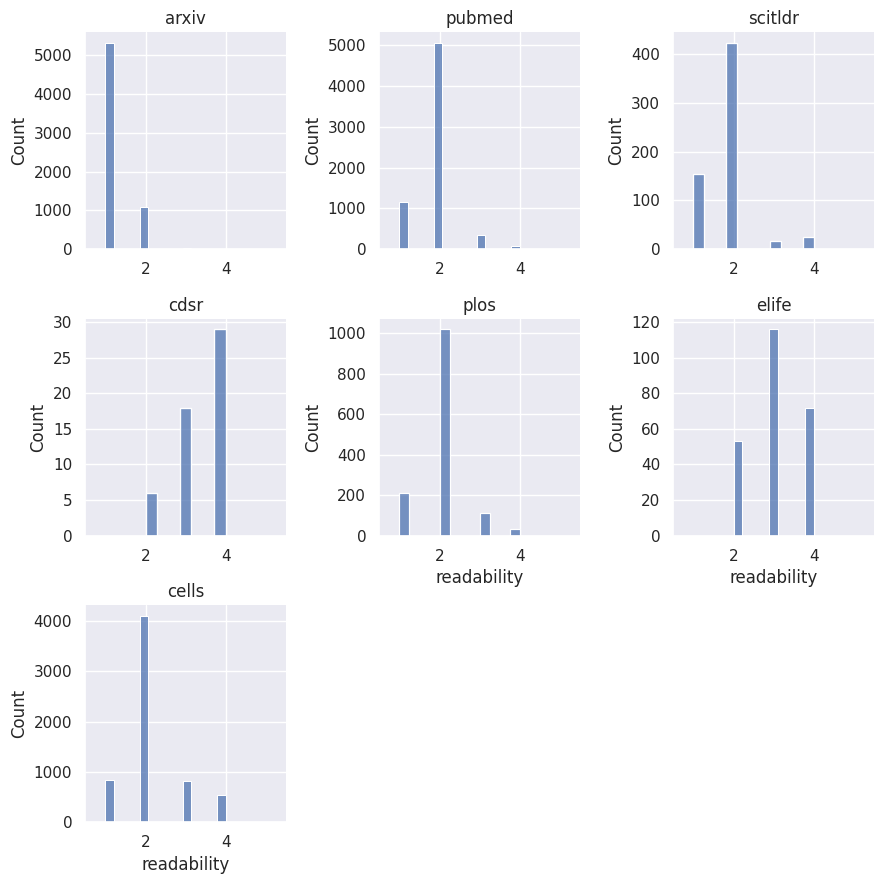

In [46]:
g = sns.FacetGrid(all_scores, 
                col="dataset", 
                col_order=[
                    "arxiv", 
                    "pubmed", 
                    "scitldr",
                    "cdsr", 
                    "plos", 
                    "elife", 
                    "cells", 
                    ],
                sharey=False, 
                sharex=False, 
                xlim=(0.5,5.5), 
                col_wrap=3
                )

# Map the histplot function to each subplot
g.map(sns.histplot, "readability")

# g.refline(x=all_scores["readability"].mean())
g.set_titles(col_template="{col_name}")
# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [47]:
summaries_dir = "/scratch4/mdredze1/icachol1/layscisum/targets"
summaries_files = glob.glob(f"{summaries_dir}/*.target")
summaries_files

['/scratch4/mdredze1/icachol1/layscisum/targets/scinews.target',
 '/scratch4/mdredze1/icachol1/layscisum/targets/elife.target',
 '/scratch4/mdredze1/icachol1/layscisum/targets/cdsr.target',
 '/scratch4/mdredze1/icachol1/layscisum/targets/eureka.target',
 '/scratch4/mdredze1/icachol1/layscisum/targets/plos.target',
 '/scratch4/mdredze1/icachol1/layscisum/targets/scitldr_all.target',
 '/scratch4/mdredze1/icachol1/layscisum/targets/cells.target',
 '/scratch4/mdredze1/icachol1/layscisum/targets/scitldr.target',
 '/scratch4/mdredze1/icachol1/layscisum/targets/arxiv.target',
 '/scratch4/mdredze1/icachol1/layscisum/targets/skj.target',
 '/scratch4/mdredze1/icachol1/layscisum/targets/pubmed.target']

In [48]:
format_str = """\
Mean: {:0.2f}
Median: {:0.0f}
Max: {:0.0f}
Min: {:0.0f}
Var:{:0.2f}
"""

def get_len(text):
    return len(text.strip().split())

def analyze_texts(texts, return_n_tokens=False):
    n_tokens = np.zeros(len(texts))
    for i, t in enumerate(texts):
        n_tokens[i] = get_len(t)
    if return_n_tokens:
        return n_tokens
    return [np.mean(n_tokens),
        np.median(n_tokens),
        np.max(n_tokens),
        np.min(n_tokens),
        np.var(n_tokens)]
        
def analyze_file(fpath, return_n_tokens=False):
    with open(fpath) as f:
        texts = f.readlines()
    return analyze_texts(texts, return_n_tokens)

In [49]:
col_names = ["dataset", "mean", "median", "max", "min", "var"]
rows = []
for f_name in summaries_files:
    dataset_name = f_name.split('/')[-1].split('.')[-2]
    # print(f"===== {dataset_name} =====")
    # analyze_file(f_name)
    stats = analyze_file(f_name)
    rows.append([dataset_name]+stats)

df = pd.DataFrame(rows, columns=col_names)
df


,dataset,mean,median,max,min,var
0,scinews,615.017670,571.0,2720.0,119.0,61598.801980
1,elife,383.091286,380.0,607.0,226.0,4361.327766
2,cdsr,221.132075,139.0,696.0,101.0,26451.850481
3,eureka,662.369307,629.5,1628.0,39.0,57528.949751
4,plos,194.696948,202.0,400.0,51.0,1481.026619
5,scitldr_all,66.645631,65.0,133.0,18.0,396.876041
6,cells,161.831247,146.0,609.0,41.0,4412.272426
7,scitldr,18.852751,18.0,44.0,3.0,57.203237
8,arxiv,163.130745,159.0,290.0,44.0,3340.795017
9,skj,142.246479,144.0,356.0,72.0,786.446290


In [50]:
elife = all_scores[all_scores['dataset'] == 'elife']
elife_ntokens  = analyze_file('/scratch4/mdredze1/icachol1/layscisum/targets/elife.target', return_n_tokens=True)
elife['n_tokens'] = elife_ntokens
elife

/tmp/ipykernel_453495/2750136913.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elife['n_tokens'] = elife_ntokens


,readability,summary,response,dataset,model,coleman_liau,n_tokens
22749,3.0,Imagine a gymnastics competition in which part...,I would rate the reading ease of this text as ...,elife,3-70B-Instruct-prompt4,10.670954,403.0
22750,4.0,"To grow and multiply , a living cell must take...",I would rate the reading ease of this text as ...,elife,3-70B-Instruct-prompt4,11.247771,329.0
22751,2.0,Our sense of number is thought to have emerged...,I would rate the reading ease of this text as ...,elife,3-70B-Instruct-prompt4,13.767383,478.0
22752,4.0,"When an embryo is developing , stem cells must...",I would rate the reading ease of this text as ...,elife,3-70B-Instruct-prompt4,9.362639,306.0
22753,3.0,Neurons communicate with one another at juncti...,I would rate the reading ease of this text as ...,elife,3-70B-Instruct-prompt4,12.321041,293.0
...,...,...,...,...,...,...,...
22985,2.0,A stem cell is a special cell that divides to ...,I would rate the reading ease of this text a 2...,elife,3-70B-Instruct-prompt4,11.416053,486.0
22986,2.0,If all the DNA contained within a single human...,I would rate the reading ease of this text as ...,elife,3-70B-Instruct-prompt4,9.304650,450.0
22987,3.0,Hybrids arise when two populations of organism...,I would rate the reading ease of this text as ...,elife,3-70B-Instruct-prompt4,15.829636,515.0
22988,2.0,"As an animal embryo develops , specific genes ...",I would rate the reading ease of this text as ...,elife,3-70B-Instruct-prompt4,11.495590,412.0


<Axes: xlabel='readability', ylabel='n_tokens'>

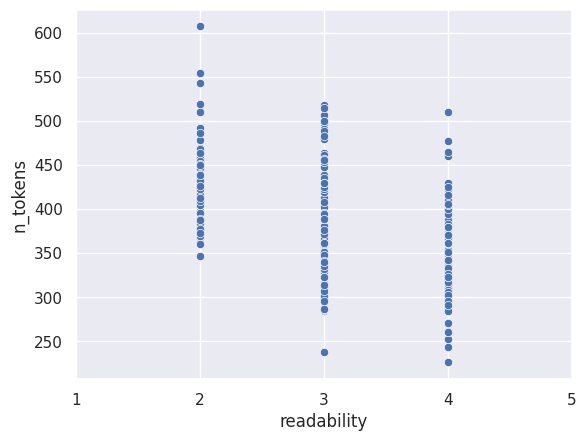

In [51]:
ax = plt.subplot()
ax.xaxis.set_ticks([1,2,3,4,5])
ax.set_xlim([1,5])
sns.scatterplot(elife, x="readability", y='n_tokens', ax=ax)

In [52]:
pearsonr(elife['readability'], elife['readability'])

PearsonRResult(statistic=1.0, pvalue=0.0)

In [53]:
all_scores['n_tokens'] = -1
for fpath in summaries_files:
    dataset_name = fpath.split('/')[-1].split('.')[-2]
    print(dataset_name)
    ntokens  = analyze_file(fpath, return_n_tokens=True)
    print(len(ntokens))
    # tmp['n_tokens'] = ntokens
    # df.loc[df['A'].isin([1, 2]), 'B'] = [10, 20]
    all_scores.loc[all_scores['dataset'] == dataset_name, 'n_tokens'] = ntokens
all_scores

scinews
4188
elife
241
cdsr
53
eureka
1010
plos
1376
scitldr_all
618


ValueError: Must have equal len keys and value when setting with an iterable

In [ ]:
pearsonr(all_scores['readability'], all_scores['n_tokens'])

PearsonRResult(statistic=0.23042170859930367, pvalue=1.068088971052248e-274)

<Axes: xlabel='readability', ylabel='n_tokens'>

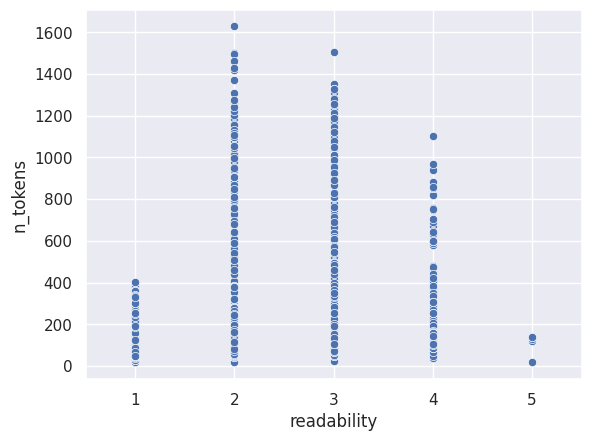

In [ ]:
ax = plt.subplot()
ax.xaxis.set_ticks([1,2,3,4,5])
ax.set_xlim([0.5,5.5])
sns.scatterplot(all_scores, x="readability", y='n_tokens', ax=ax)